# Integrated CA2: Machine Learning and Data Viz

Table of contents:

- Data Exploration
- Data Preparation
- EDA
- Feature Engineering
    - Elbow Method 
    - Silhouette Score
- Clustering and Plots
    - Dendogram
    - Hierarchical
    - K-Means 
    - Fuzzy C-Means
    - DBSCAN
        - K-distance plot
        - Reachability distance with OPTICS
- Collaborative Filtering Recomender - Euclidean Distance
- Recommendation Evaluation: Cosine vs Ecuclidean
- Results
    - RMSE, MAE and NDCG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn_extra.cluster import KMedoids
from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.cluster import OPTICS
from sklearn.neighbors import NearestNeighbors

# DATA EXPLORATION

# Fixing reading error
ratings = pd.read_csv('rating.csv', encoding='latin1')
tags = pd.read_csv('tags.csv', encoding='latin1')
movies = pd.read_csv('movies.csv', encoding='latin1')

# Lets see some data samples
print("Movies Sample:")
display(movies.head())
print("Ratings Sample:")
display(ratings.head())
print("Tags Sample:")
display(tags.head())

# Merge datasets
merged = ratings.merge(movies, on="movieId", how="left").merge(tags, on=["movieId", "userId"], how="left")

print("Merged Dataset Sample:")
display(merged.head())


Movies Sample:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings Sample:


,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


Tags Sample:


,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,Eddie Murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


Merged Dataset Sample:


,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,12882,1,4.0,1147195252,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN
1,12882,32,3.5,1147195307,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,NaN,NaN
2,12882,47,5.0,1147195343,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN
3,12882,50,5.0,1147185499,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN
4,12882,110,4.5,1147195239,Braveheart (1995),Action|Drama|War,NaN,NaN


In [2]:
merged.describe()

,userId,movieId,rating,timestamp_x,timestamp_y
count,320363.000000,320363.000000,320363.000000,3.203630e+05,8.181200e+04
mean,68542.790494,13422.537063,3.544334,1.214321e+09,1.275693e+09
std,41183.757423,23353.572760,1.009757,1.148323e+08,7.842651e+07
min,316.000000,1.000000,0.500000,8.767674e+08,1.136772e+09
25%,32780.000000,1269.000000,3.000000,1.139446e+09,1.217731e+09
50%,66455.000000,3034.000000,3.500000,1.215578e+09,1.278599e+09
75%,104037.000000,6979.000000,4.000000,1.303509e+09,1.334605e+09
max,138200.000000,112852.000000,5.000000,1.427779e+09,1.427746e+09


In [3]:
# Shape 
merged.shape

(320363, 8)

In [4]:
# DATA PREPARATION

# Check missing values
print("Missing values before cleanup:")
print(merged.isnull().sum())

Missing values before cleanup:
userId              0
movieId             0
rating              0
timestamp_x         0
title               0
genres              0
tag            238551
timestamp_y    238551
dtype: int64


In [5]:
# Dropping NaN (Won't affect clustering)
merged = merged.dropna()

In [6]:
# Checking
print(merged.isnull().sum())

userId         0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
tag            0
timestamp_y    0
dtype: int64


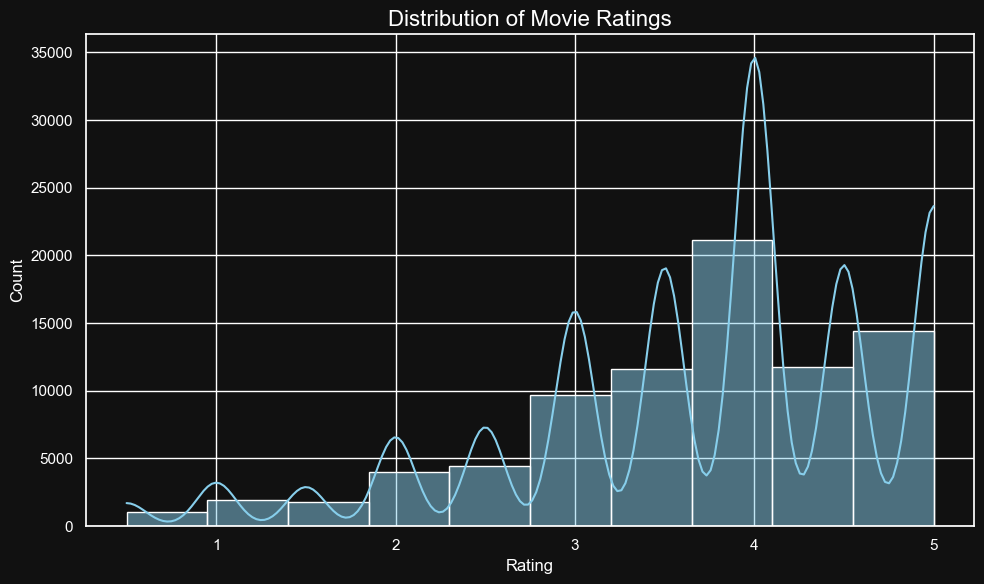

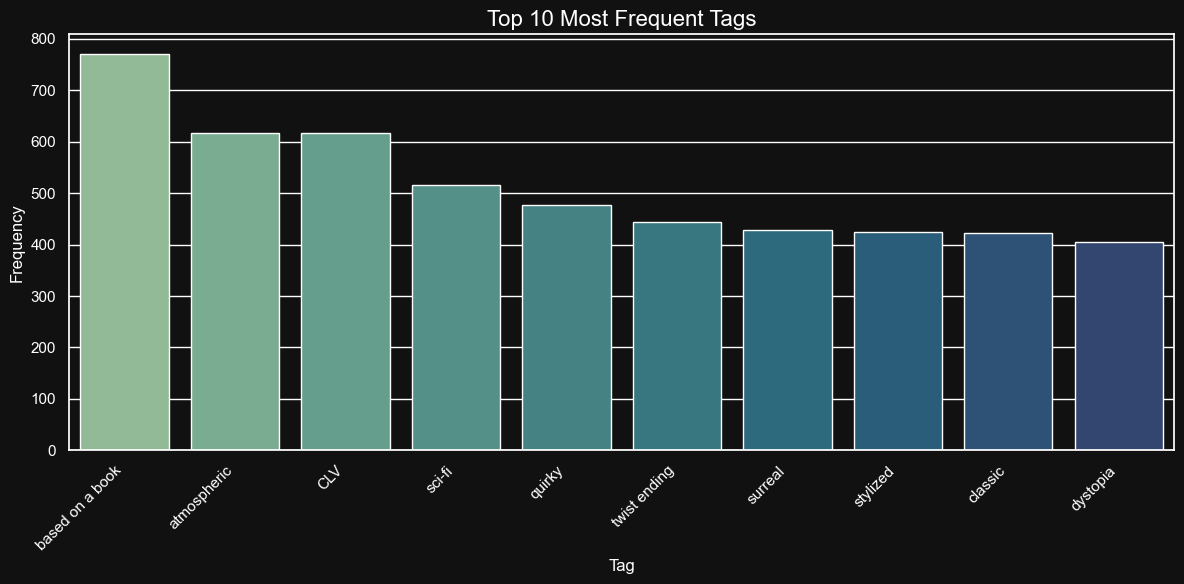

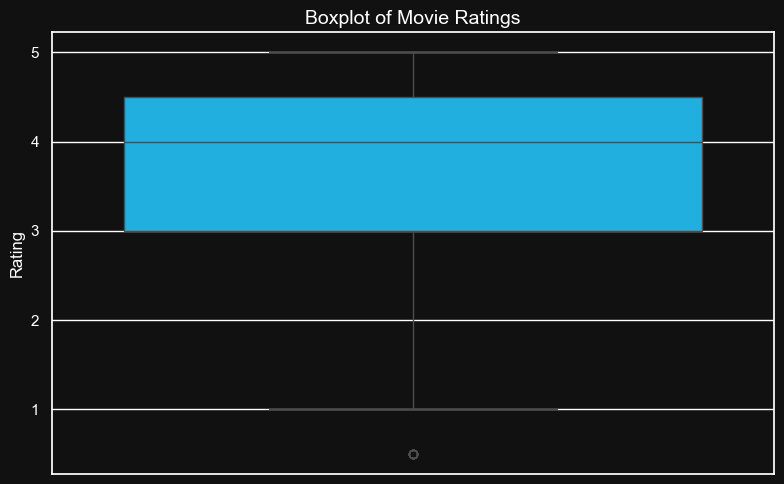

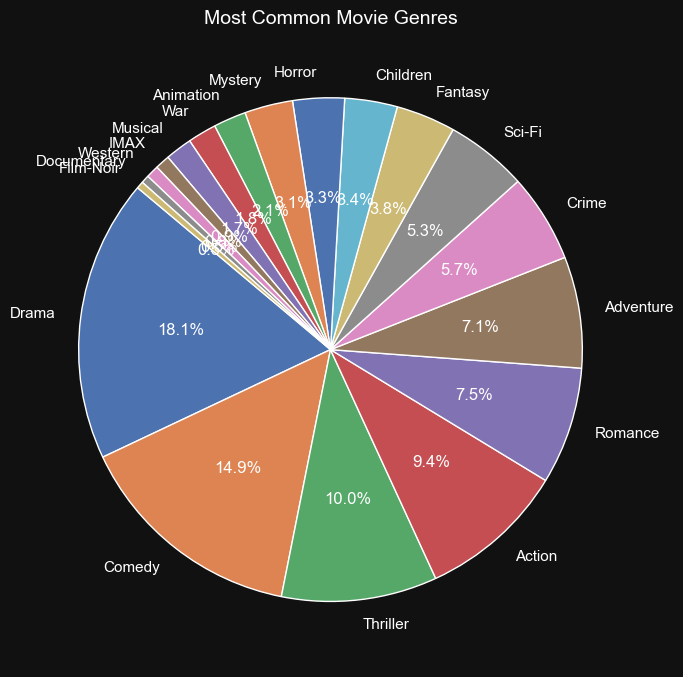

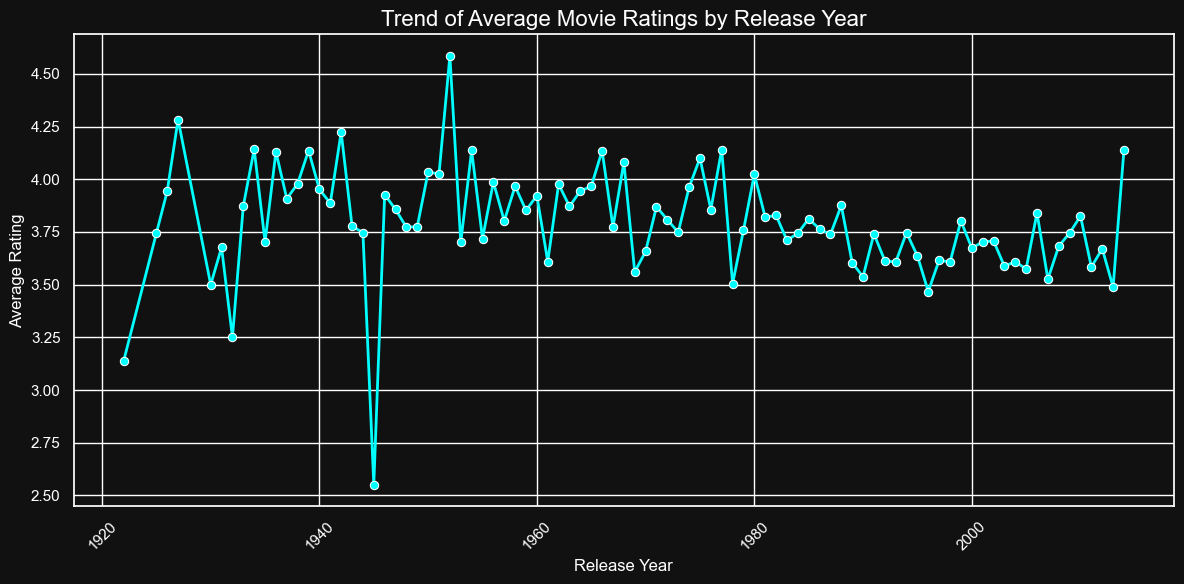

In [ ]:
# EDA

# Dak background to fit Streamlit Dashaboard Design
plt.style.use('dark_background')
sns.set_theme(style="darkgrid", rc={
    'axes.facecolor': '#111111',
    'figure.facecolor': '#111111',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.edgecolor': 'white'
})

# 1. Distribution of Movie Ratings
plt.figure(figsize=(10, 6))
sns.histplot(merged['rating'], bins=10, kde=True, color='skyblue', edgecolor='white')
plt.title("Distribution of Movie Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()

# 2. Top 10 Most Frequent Tags
top_tags = tags['tag'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tags.index, y=top_tags.values, palette='crest')
plt.title("Top 10 Most Frequent Tags", fontsize=16)
plt.xlabel("Tag", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Box Plot: Looking for outliers
plt.figure(figsize=(8, 5))
sns.boxplot(y=merged['rating'], color='deepskyblue')
plt.title('Boxplot of Movie Ratings', fontsize=14)
plt.ylabel('Rating', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Most Common Genres (Pie Chart)
genre_counts = movies['genres'].str.split('|').explode().value_counts()
plt.figure(figsize=(7, 7))
plt.pie(
    genre_counts.values,
    labels=genre_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'color': 'white'}
)
plt.title('Most Common Movie Genres', fontsize=14, color='white')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 5. Trend Line by Year

# Getting the Release year by getting the 4 digits of the row
# Passing them to float
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Merging, getting the rate means and grouping by year for plotting
ratings_with_year = merged.merge(movies[['movieId', 'year']], on='movieId')
yearly_avg = ratings_with_year.groupby('year')['rating'].mean().reset_index().dropna().sort_values('year')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_avg, x='year', y='rating', marker='o', color='cyan', linewidth=2)
plt.title("Trend of Average Movie Ratings by Release Year", fontsize=16)
plt.xlabel("Release Year", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Charts were darkened to fit the demographic in mind, this demographic is too used to Netflix, Spotify, Twitter, and all these black-themed platforms.

The section of each specific chart was explicit for the matter to study:

- Jupyter Notebook:

Interesting results, first of all, this **Histogram** helps us to see where the density of values lies the most. Movie distribution ratings seem to have a higher density in the 4 area, out of 5 means that people normally love movies. Ratings seem to follow a normal distribution, which is good because we are using this feature later.

Second, **Bar charts** are great for comparing sums or counts. The top one, movies based on books, is the top one, and by far, I realized that movies based on previous books tend to attract most people, based on their tags. People like to go watch a movie based on their favorite books, or maybe they think that if the movie has a book already, at least the script will be good.

Third, the **Box plot** was selected for this specific metric study. Some outliers are found in this dataset; nothing to worry about so much.

**Pie Chart:** A great tool to see the size of something compared to all, in this case, genre dominance, drama, and comedy, seems to lead the ranking of top-rated movies, who does not love to laugh?

**Trend of Average Movie Ratings by Release Year**: We can see that movies had a spike in the upward direction since the millennium 2, older movies seem to have a higher making, and a very interesting point is that the trend line of average movie ratings has been declining in the 40s, that's impressive

- Inside the Dashboard

**Heatmap** was chose because it shows perfectly the realtionship any feture has with the compated ones, in this case the heatmap inside the dashboard shows an excellent comparison betwwen the actual user with its closst ones.

The dashboard has an **Horizontal bar chart** that shows in a ranking the to 5 predictions amde the algorythim, everyti9me you see an horizontal bar chart you can smell the competition, bar charts are an amazing tool to compare one feature against another, it shows the difference they have in just in picture and whic one is the top, whar are in the middle and which one is the lesser.

Again a **Pie chart** was drawn in the Dashboard but this same same as the horizontal bra chart they were dran with Plotly, a way to plot interactive charts with Python, this time this pie chart shows the genre distribution of the specific user, it allos the user to see how much he prefers a particular genre watcheing the whole size of his movies watched. A pie chart demonstrates how big or small something belongs to a whole, in this case, how many movies of each genre were seen





In [165]:
# FEATURE ENGINEERING
# We’ll extract features for clustering: average rating, count, genre encoding

# Average rating and rating count per movie
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Merging with genres
movie_features = movie_stats.merge(movies, on='movieId')

# Genres One-hot encoding
genres_dummies = movie_features['genres'].str.get_dummies(sep='|')

# Concat all features
final_features = pd.concat([movie_features[['movieId', 'avg_rating', 'rating_count']], genres_dummies], axis=1)
final_features.set_index("movieId", inplace=True)

# Scaling for clustering
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(final_features)


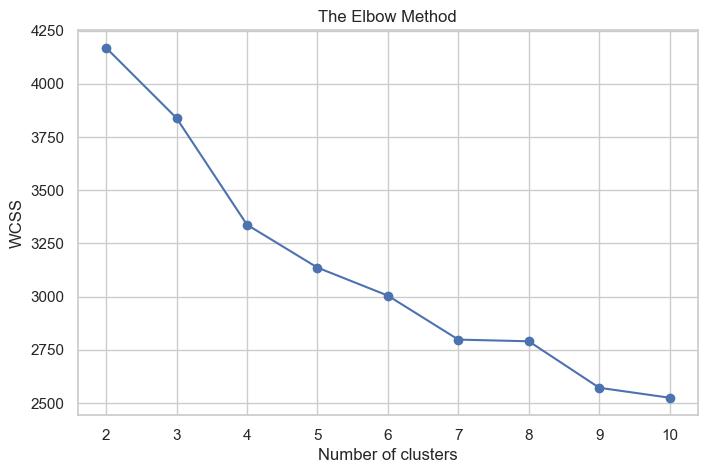

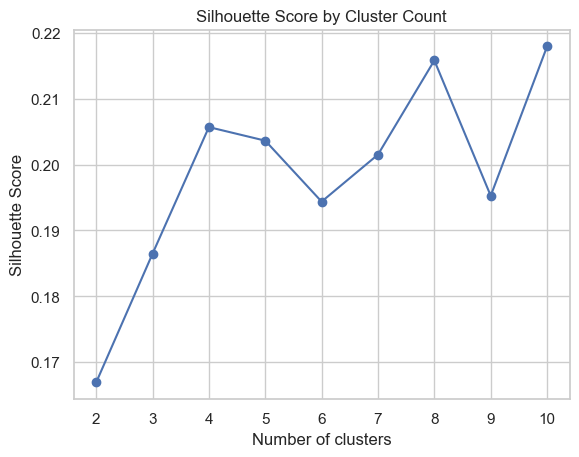

In [151]:
# Elbow Method to choose best k
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

# Silhouette Score for each k
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score by Cluster Count')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Elbow Method**: The moment the line starts to straighten is the best moment to pick the elbow. Based on what I see, I will take 4 clusters.

**Silhouette Score**: The closest point to one is a good fit for a cluster. That said, I'm still picking four clusters from this chart.


In [ ]:
# Lets PCA the data to improve clustetring
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

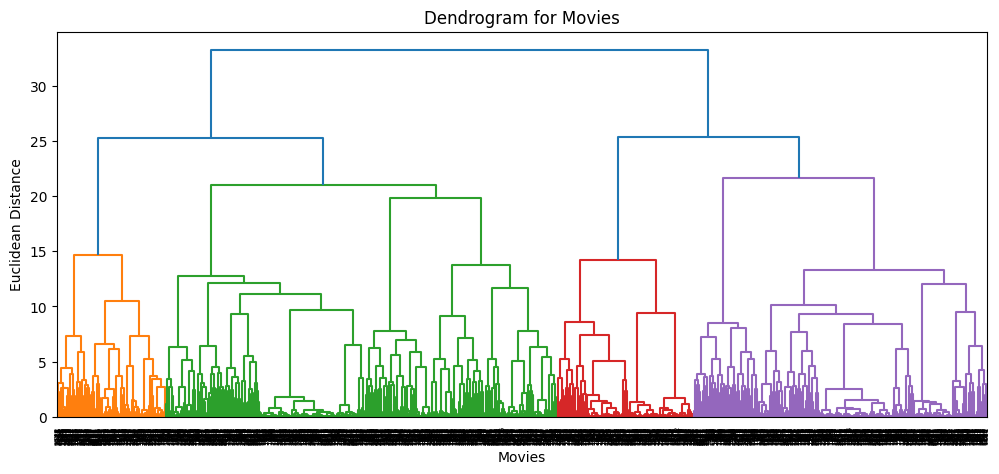

In [137]:
# CLUSTERING

# Dendrogram Plot
# White background
plt.style.use('default')
plt.figure(figsize=(12, 5))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrogram for Movies")
plt.xlabel("Movies")
plt.ylabel("Euclidean Distance")
plt.show()



This **Dendogram** reaffirms our previous selection of clusters: 4 clearly, it can be seen that 4 clusters will be beneficial for this scenario. As we can see there is 4 prominent colors as well as the lenght of the Eucldicean Distance shows that those 4 clusters have significance difference among them.

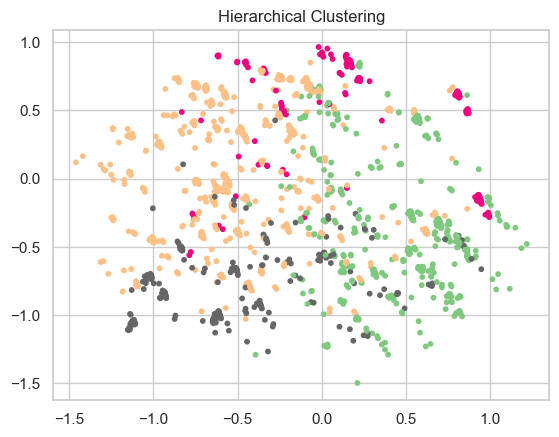

Agglomerative Clustering Summary:


,avg_rating,rating_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Agglomerative Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.274107,95.419314,0.074968,0.194409,0.153748,0.264295,0.800508,0.078780,0.041931,0.242694,...,0.001271,0.008895,0.016518,0.132147,0.020330,0.073698,0.083863,0.034307,0.005083,0.013977
1,3.473531,105.696768,0.256654,0.104563,0.002852,0.000951,0.085551,0.264259,0.000000,0.674905,...,0.023764,0.180608,0.008555,0.001901,0.146388,0.025665,0.134030,0.423954,0.084601,0.038973
2,3.384529,95.825613,0.051771,0.000000,0.000000,0.000000,0.531335,0.057221,0.000000,0.686649,...,0.008174,0.002725,0.000000,0.005450,0.054496,0.994550,0.010899,0.098093,0.040872,0.000000
3,3.201878,146.425170,0.870748,0.659864,0.034014,0.023810,0.119048,0.006803,0.000000,0.023810,...,0.000000,0.047619,0.129252,0.006803,0.027211,0.105442,0.428571,0.442177,0.034014,0.000000


Movies in Cluster 0:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
4,5,Father of the Bride Part II (1995),Comedy
11,13,Balto (1995),Adventure|Animation|Children
16,18,Four Rooms (1995),Comedy


Movies in Cluster 1:


,movieId,title,genres
5,6,Heat (1995),Action|Crime|Thriller
10,12,Dracula: Dead and Loving It (1995),Comedy|Horror
12,14,Nixon (1995),Drama
14,16,Casino (1995),Crime|Drama
18,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller


Movies in Cluster 2:


,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
6,7,Sabrina (1995),Comedy|Romance
9,11,"American President, The (1995)",Comedy|Drama|Romance
15,17,Sense and Sensibility (1995),Drama|Romance


Movies in Cluster 3:


,movieId,title,genres
7,9,Sudden Death (1995),Action
8,10,GoldenEye (1995),Action|Adventure|Thriller
13,15,Cutthroat Island (1995),Action|Adventure|Romance
37,44,Mortal Kombat (1995),Action|Adventure|Fantasy
52,66,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller


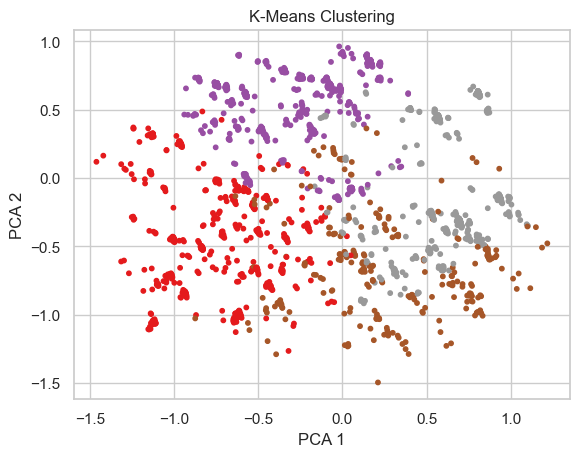

K-Means Cluster Summary:


,avg_rating,rating_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Agglomerative Cluster
KMeans Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.228423,129.173599,0.725136,0.287523,0.003617,0.003617,0.047016,0.238698,0.000000,0.132007,...,0.200723,0.056058,0.000000,0.130199,0.057866,0.374322,0.739602,0.025316,0.019892,1.786618
1,3.576742,93.828962,0.085519,0.064994,0.012543,0.019384,0.001140,0.161916,0.031927,0.923603,...,0.066135,0.005701,0.036488,0.116306,0.212087,0.060433,0.215507,0.094641,0.031927,1.095781
2,3.306738,130.713768,0.242754,0.775362,0.416667,0.572464,0.471014,0.036232,0.003623,0.105072,...,0.028986,0.083333,0.163043,0.036232,0.090580,0.163043,0.010870,0.010870,0.018116,0.807971
3,3.248829,94.089421,0.076826,0.034005,0.007557,0.049118,0.998741,0.099496,0.005038,0.312343,...,0.044081,0.001259,0.041562,0.017632,0.299748,0.040302,0.047859,0.022670,0.010076,0.624685


Movies in Cluster 0:


,movieId,title,genres
5,6,Heat (1995),Action|Crime|Thriller
7,9,Sudden Death (1995),Action
8,10,GoldenEye (1995),Action|Adventure|Thriller
13,15,Cutthroat Island (1995),Action|Adventure|Romance
18,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller


Movies in Cluster 1:


,movieId,title,genres
12,14,Nixon (1995),Drama
14,16,Casino (1995),Crime|Drama
15,17,Sense and Sensibility (1995),Drama|Romance
20,22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller
22,24,Powder (1995),Drama|Sci-Fi


Movies in Cluster 2:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
11,13,Balto (1995),Adventure|Animation|Children
27,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
37,44,Mortal Kombat (1995),Action|Adventure|Fantasy


Movies in Cluster 3:


,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
6,7,Sabrina (1995),Comedy|Romance
9,11,"American President, The (1995)",Comedy|Drama|Romance


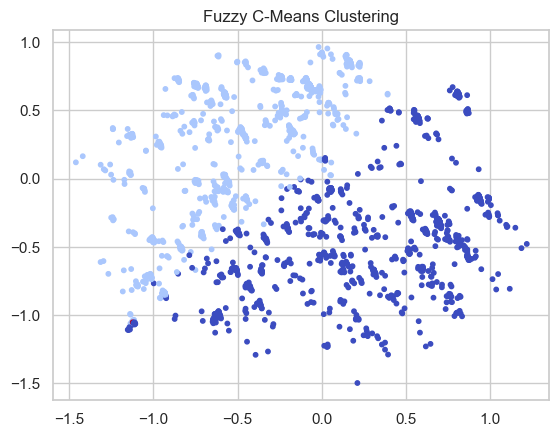

Fuzzy C-Means Clustering Summary:


,avg_rating,rating_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Agglomerative Cluster,KMeans Cluster
FCM Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.240821,105.530549,0.228925,0.240526,0.083527,0.140758,0.724671,0.085847,0.023975,0.187162,...,0.033256,0.064192,0.026295,0.218871,0.142305,0.064192,0.021655,0.020108,0.893271,2.255220
1,3.499649,105.954395,0.254561,0.120232,0.021559,0.028192,0.010779,0.208955,0.001658,0.761194,...,0.014096,0.022388,0.135987,0.164179,0.126036,0.460199,0.074627,0.021559,1.252073,0.742123
3,3.391941,273.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000


Movies in Cluster 0:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Movies in Cluster 1:


,movieId,title,genres
5,6,Heat (1995),Action|Crime|Thriller
8,10,GoldenEye (1995),Action|Adventure|Thriller
12,14,Nixon (1995),Drama
14,16,Casino (1995),Crime|Drama
15,17,Sense and Sensibility (1995),Drama|Romance


Movies in Cluster 2:


,movieId,title,genres


Movies in Cluster 3:


,movieId,title,genres
2140,8644,"I, Robot (2004)",Action|Adventure|Sci-Fi|Thriller


In [132]:
# ----------------------  Agglomerative Clustering (Hierarchical Clustering)------------------------ #

agg = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
labels_agg = agg.fit_predict(X_scaled)

plt.scatter(components[:, 0], components[:, 1], c=labels_agg, cmap='Accent', s=10)
plt.title("Hierarchical Clustering")
plt.show()

# Take the cluster into its own df
final_features['Agglomerative Cluster'] = labels_agg

# Groupping by AVG
agg_cluster_summary = final_features.groupby('Agglomerative Cluster').mean()

# Display
print("Agglomerative Clustering Summary:")
display(agg_cluster_summary)

# To see the movies in each cluster:
for cluster in range(4):
    cluster_movies = final_features[final_features['Agglomerative Cluster'] == cluster]
    print(f"Movies in Cluster {cluster}:")
    display(movies[movies['movieId'].isin(cluster_movies.index)].head())


# --------------------------------  K MEANS CLUSTERING --------------------------------------- #

kmeans = KMeans(n_clusters=4)
labels_kmeans = kmeans.fit_predict(X_scaled)

plt.scatter(components[:, 0], components[:, 1], c=labels_kmeans, cmap='Set1', s=10)
plt.title("K-Means Clustering")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Take the cluster into its own df
final_features['KMeans Cluster'] = labels_kmeans

# Groupping by AVG
kmeans_cluster_summary = final_features.groupby('KMeans Cluster').mean()

# Display
print("K-Means Cluster Summary:")
display(kmeans_cluster_summary)

# To see the movies in each cluster:
for cluster in range(4):
    cluster_movies = final_features[final_features['KMeans Cluster'] == cluster]
    print(f"Movies in Cluster {cluster}:")
    display(movies[movies['movieId'].isin(cluster_movies.index)].head())


# --------------------------------------- FUZZY C-MEANS CLUSTERING------------------------------------------#

fcm = FCM(n_clusters=4)
fcm.fit(X_scaled)

fcm_labels = fcm.predict(X_scaled)
plt.scatter(components[:, 0], components[:, 1], c=fcm_labels, cmap='coolwarm', s=10)
plt.title("Fuzzy C-Means Clustering")
plt.show()

# Take the cluster into its own df
final_features['FCM Cluster'] = fcm_labels

# Groupping by AVG
fcm_cluster_summary = final_features.groupby('FCM Cluster').mean()

# Display
print("Fuzzy C-Means Clustering Summary:")
display(fcm_cluster_summary)

# To see the movies in each cluster:
for cluster in range(4):
    cluster_movies = final_features[final_features['FCM Cluster'] == cluster]
    print(f"Movies in Cluster {cluster}:")
    display(movies[movies['movieId'].isin(cluster_movies.index)].head())




To get the best of this DBSCAN Clustering, I will:

- Plot DBSCAN Plot: to have a broader view of how this clustering would work in this particular scenario
- Plot K-Distance Graph: To find the perfect Epsilon for Clustering. In this case was 0.5 eps
- Plot Reachability distances ordered by the OPTICS algorithm: With these powerful results, I will be able to see if I am going to keep moving forward with the DBSCAN or not. Let's see the distribution

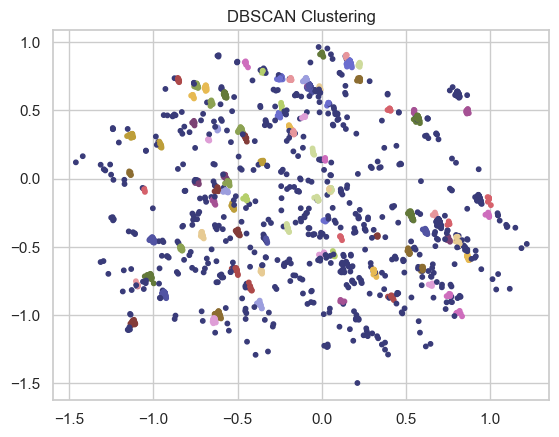

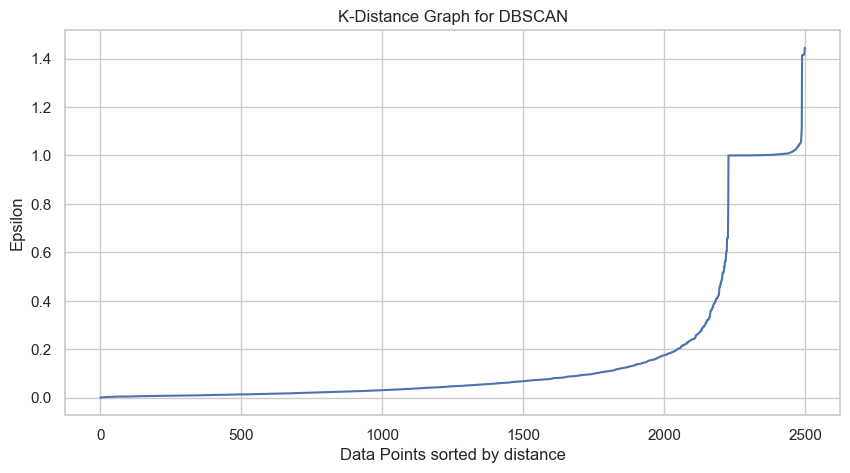

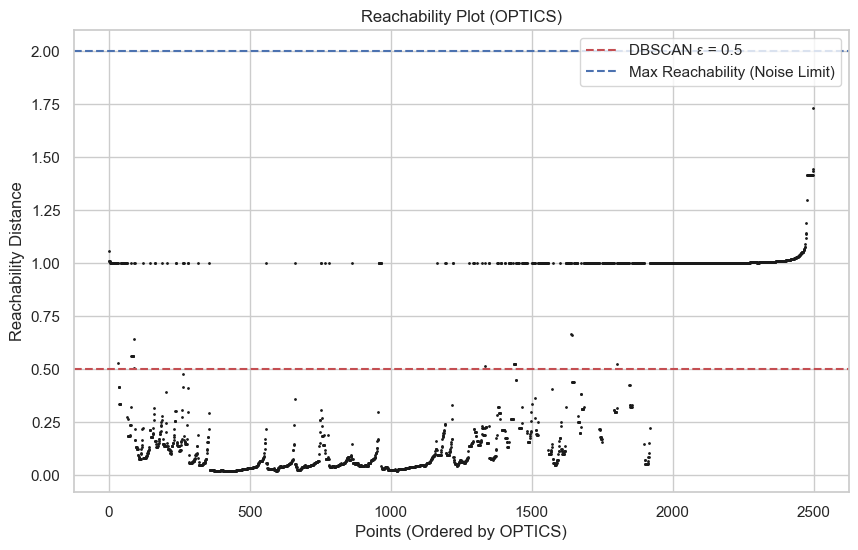

DBSCAN Clustering Summary:


,avg_rating,rating_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Agglomerative Cluster,KMeans Cluster,FCM Cluster
DBSCAN Cluster,,,,,,,,,,,,,,,,,,,,,
-1,3.395990,121.300455,0.362671,0.344461,0.172989,0.200303,0.349014,0.182094,0.018209,0.333839,...,0.107739,0.171472,0.221548,0.227618,0.312595,0.054628,0.060698,1.033384,1.383915,0.418816
0,3.186895,132.600000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
1,3.142595,97.478723,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000
2,3.453463,96.506024,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000
3,3.125131,79.680203,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,3.624997,74.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
90,3.599607,228.600000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,0.000000
91,3.429988,185.090909,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000


In [133]:
#  --------------------------- DBSCAN Clustering ------------------------------- #

# To get the best of this DBSCAN clustering 

# DBSCAN clustering with epsilon set based on K-distance graph analysis

# Fit DBSCAN using the chosen eps=0.5 and for best practices; min_samples=5
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_scaled)

# Plot DBSCAN PCA'd cluster
plt.scatter(components[:, 0], components[:, 1], c=labels_db, cmap='tab20b', s=10)
plt.title("DBSCAN Clustering")
plt.show()

# K-distance plot

# Computing the distance to the nearest neighbor
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Plot
distances = np.sort(distances[:, 1])
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

# OPTICS clustering

# Fiting the OPTICS with the same chosen attributes
clust = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clust.fit(X_scaled)

# Reachability distance
space = np.arange(len(X_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

# Plot Reachability Distance
plt.figure(figsize=(10, 6))
plt.plot(space, reachability, 'k.', markersize=2)

# Red dashed line shows the chosen epsilon
plt.axhline(y=0.5, c='r', ls='--', label='DBSCAN ε = 0.5')

# Blue dashed line is the upper threshold
plt.axhline(y=2, c='b', ls='--', label='Max Reachability (Noise Limit)')

plt.title('Reachability Plot (OPTICS)')
plt.ylabel('Reachability Distance')
plt.xlabel('Points (Ordered by OPTICS)')
plt.legend()
plt.show()

# Clusters Sample
# Take the cluster into its own df
final_features['DBSCAN Cluster'] = labels_db

# Groupping by AVG
dbscan_cluster_summary = final_features.groupby('DBSCAN Cluster').mean()

# Display
print("DBSCAN Clustering Summary:")
display(dbscan_cluster_summary)

# For the DBSCAN Clustering, clusters are not going to be printed because it will be shown below; this clustering technique found +90 possible clusters for this movie clustering.


Results:

 - **Hierarchical Clustering:** It shows a good fit for this dataset. The chart looks mostly correct, but it leaves one with a feeling that it could be better. When reviewing the movies in the clusters I see that there is a significant large diversity of genres instead of having an specific one per cluster, that could be supposed as well when seeing the chart, there is the cluster there but sometimes dots seems a bit far away from its core point, making sense of what I just mentioned.

 - **K-Means Clustering:**  A Simple clustering technique is the best-looking one and the one I will be using for this Movie recommendation and classification system. Dots seem to be homogeneous in their place, fitting the 4 clusters, still the Hierarchical falls very close to it.

 - **Fuzzy C-Means Clustering:** Vaguely, it only created 3 clusters, and by looking at the chart, it is not the type of clustering that I am looking for right now

 - **DBSCAN Clustering:** after taking the time to fine-tune it, it created +90 clusters, and based on the chart, they are too widespread along the dataset, making it not suitable for this particular scenario. An Epsilon of 0.5 was found thanks to the K-distance Graph and the Reachability Plot made with the OPTICS algorythim showed that yes there are a good amount of values compresed at the 0.5 density benchmark but still showd that there is an important amount of data hanging at the 1.00 eps zone going parabolic at the end, showcasing a good amount of unstructured values, basically too many outliers and noise.

For all these reasons, **K-Means Clustering** is the preferred clustering technique for this study.


In [134]:
# COLLABORATIVE FILTERING RECOMENDER - EUCLIDEAN DISTANCE

# User-item Pivot Table
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Euclidean distance
euc_dist = euclidean_distances(user_movie_matrix)

# To not compare users to themselves
np.fill_diagonal(euc_dist, np.inf) 

# Distance to similarity
euc_sim = 1 / (1 + euc_dist)

# df it
euc_sim_df = pd.DataFrame(euc_sim, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Lets predict predicted movies fro user 12882
user_id = 12882

# Lets run the similarity by users
similar_users = euc_sim_df[user_id].sort_values(ascending=False)

# Getting the top 5 and their movies
top_similar_users = similar_users.head(5).index
top_users_ratings = user_movie_matrix.loc[top_similar_users]

# Content-based filtering: Average ratings from these similar users
average_ratings = top_users_ratings.mean()

# Getting rid off movies our target user has already watched
user_seen_movies = user_movie_matrix.loc[user_id]
unrated_movies = average_ratings[user_seen_movies == 0]

# Top 5 highest unseen movies
top_recommendations = unrated_movies.sort_values(ascending=False).head(5)

# final moovie titles
recommended_movies = movies[movies['movieId'].isin(top_recommendations.index)]

# Display 
recommended_movies

,movieId,title,genres
175,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
562,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1883,5218,Ice Age (2002),Adventure|Animation|Children|Comedy
2044,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
2364,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX


Amazing, this Collaborative filtering recommender successfully pointed out the top 5 unseen movie recommendations for our user, based on others' similarities.
By leveraging **content-based filtering** and averaging the ratings from its similar users, the algorithm was able to recommend well-suited movies ready to be seen by the user.

But now, one question arises: How do we test this? Let's test it back with its cousin, the Cosine Similarity, evaluate their performance, and see if it's as reliable as it shows

In [ ]:
# RECOMMENDATION EVALUATION: COSINE vs EUCLIDEAN

# Lets do a train and test splits
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Sample only 1000 test rows to speed up the machine
test_df = test_df.sample(1000, random_state=42) 

# Pivot Table for training
user_movie_matrix_train = train_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
# ----------------------- Cosine similarity between users ------------------------------# 

cos_sim = cosine_similarity(user_movie_matrix_train)  

# Avoiding comparing a user to themselves
np.fill_diagonal(cos_sim, 0)  

# Pivot Table to df
cos_sim_df = pd.DataFrame(cos_sim, index=user_movie_matrix_train.index, columns=user_movie_matrix_train.index)  

# ---------------------------------- Euclidean distance -------------------------------#

euc_dist = euclidean_distances(user_movie_matrix_train)  

# Avoiding comparing a user to themselves
np.fill_diagonal(euc_dist, np.inf)  

# Convert distance to similarity
euc_sim = 1 / (1 + euc_dist)  

# Pivot Table to df
euc_sim_df = pd.DataFrame(euc_sim, index=user_movie_matrix_train.index, columns=user_movie_matrix_train.index) 

In [ ]:
# Predicting ratings def
def predict_rating(user_id, movie_id, sim_df, rating_matrix, k=5):

    # Checking if user or movie exists in Pivot Table
    if user_id not in rating_matrix.index or movie_id not in rating_matrix.columns:
        return np.nan 
    
    # Selecting the most similar users and sorting
    sim_users = sim_df[user_id].sort_values(ascending=False)
    
    # Ltes get only users who rated the movie
    users_who_rated = rating_matrix[rating_matrix[movie_id] > 0].index  
    sim_users = sim_users[sim_users.index.isin(users_who_rated)].head(k)  
    
    # Returning NaN if empty
    if sim_users.empty: 
        return np.nan
    
    # Return the AVG of the predicted rating of the top k similar users
    return rating_matrix.loc[sim_users.index, movie_id].mean() 


# Calling the function to both Algorythims
test_df['cosine_pred'] = test_df.apply(lambda row: predict_rating(row['userId'], row['movieId'], cos_sim_df, user_movie_matrix_train), axis=1)
test_df['euclidean_pred'] = test_df.apply(lambda row: predict_rating(row['userId'], row['movieId'], euc_sim_df, user_movie_matrix_train), axis=1)

In [136]:
# Drop Nan
test_eval = test_df.dropna(subset=['cosine_pred', 'euclidean_pred'])

# RMSE
rmse_cosine = np.sqrt(mean_squared_error(test_eval['rating'], test_eval['cosine_pred']))
rmse_euclidean = np.sqrt(mean_squared_error(test_eval['rating'], test_eval['euclidean_pred']))

# MAE
mae_cosine = mean_absolute_error(test_eval['rating'], test_eval['cosine_pred'])
mae_euclidean = mean_absolute_error(test_eval['rating'], test_eval['euclidean_pred'])

# NDCG
ndcg_cosine = ndcg_score([test_eval['rating']], [test_eval['cosine_pred']])
ndcg_euclidean = ndcg_score([test_eval['rating']], [test_eval['euclidean_pred']])

# Showing results
results_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'NDCG'],
    'Euclidean Similarity': [rmse_euclidean, mae_euclidean, ndcg_euclidean],
    'Cosine Similarity': [rmse_cosine, mae_cosine, ndcg_cosine]
})

results_df

,Metric,Euclidean Similarity,Cosine Similarity
0,RMSE,1.009931,0.925116
1,MAE,0.789600,0.723200
2,NDCG,0.970903,0.972410


RMSE, MAE, NDCG: These metrics will work as our accuracy scores for the machine learning algorithm, and similar to them, the closer the number is to 1, the better it represents the actual data.

In this case, the winner by far was the **Euclidean Similarity**, with an RMSE of 1.009931, and not only was one metric above, but out of 2 showed favor to this similarity for this case.